# Linear regression through clustering

Sometimes outliers can seriously hinder the overall performance of regression methods based on minimisation of mean squared error. The following exercise explains how to detect problems with outliers and how to use model based clustering to detect outliers. We also show how to rephrase piecewise linear regression, where the response to input radically changes in a single point, as a clustering task.    

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import copy 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from pandas import Series
from pandas import DataFrame

from pandas import Categorical
from pandas.api.types import CategoricalDtype
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import uniform 

# Local imports
from common import *
from convenience import *

## I. Datasets 

In this notebook, we consider datasets
* [`challenge-1.csv`](./data/gmm-regression-challenges/challenge-1.csv)
* [`challenge-2.csv`](./data/gmm-regression-challenges/challenge-2.csv)

from the directory `data/regression-challenges`.

### Challenge I. Filtering out outliers to improve polynomial fit

In the first challenge dataset, the normal polynomial response seems to be mixed with datapoints that are completely random.  

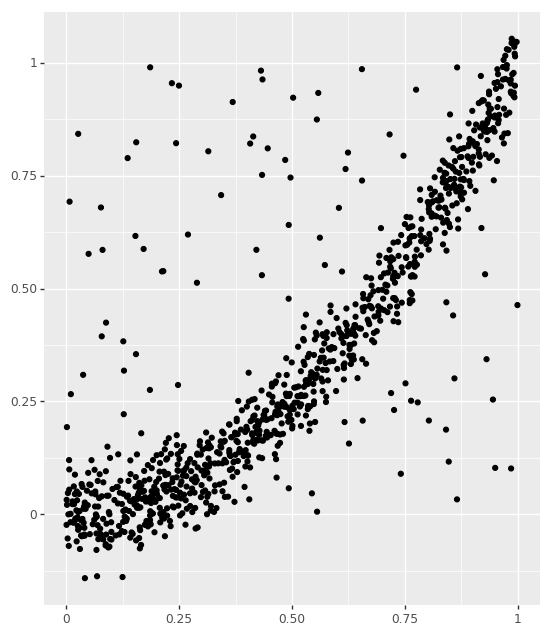

<ggplot: (7547214656)>

In [2]:
df1 = pd.read_csv('data/regression-challenges/challenge-1.csv', usecols = [1,2])

p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Challenge II. Piecewise linear regression

In the second dataset, the response seems to be following a linear path but in two regimes. To find a good fit, we need to find the location of the angle point $x_0$.

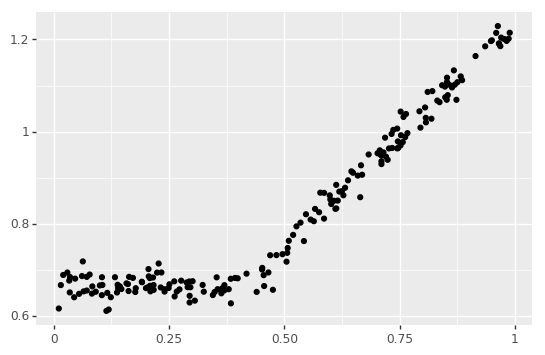

<ggplot: (7547285687)>

In [3]:
df2 = pd.read_csv('data/regression-challenges/challenge-2.csv', usecols = [1,2])

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

## III. General recipe for hard clustering

**Model:** Both regression tasks can be modelled as follows: 
* There are two data sources $\mathcal{D}_1$ and $\mathcal{D}_2$ with different data generation models with parameters $\boldsymbol{\Theta}_1$ and $\boldsymbol{\Theta}_2$. 
* We see only the observations $(x_1,y_1),\ldots, (x_n, y_n)$. The corresponding cluster lables $z_1,\ldots,z_n$ are unknown. 
* Our task is to find parameter values $\boldsymbol{\Theta}_1$ and $\boldsymbol{\Theta}_2$ together with labels $\boldsymbol{z}$ that are solutions to the maximisation task

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max\,.
\end{align*}

**First challenge dataset:**
* Both sources generate $x$ values with the same probability distribution. 
* Source $\mathcal{D}_1$ generates responses according to the model $y\sim ax^2+bx+c+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,\sigma^2)$.
* Source $\mathcal{D}_2$ generates responses according to the model $y\sim \mathrm{Unif}[-M,+M]$ for some large $M$.

**Second challenge dataset:**

* Values of $x$ generated by $\mathcal{D}_1$ are in the range $(-\infty, x_0)$.
* Values of $x$ generated by $\mathcal{D}_2$ are in the range $[x_0,\infty)$.
* Source $\mathcal{D}_i$ generates responses according to the model $y\sim a_ix+b_ix+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,\sigma^2)$.

**Inference:** To solve the maximisation task we can use an iterative maximisation procedure similar to k-means algorithm:

* **M0:** Start with random parameter values $\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2$.
* **M1:** Assign points to the most probable data source: 
  
  \begin{align*}
  \boldsymbol{z}^* =\mathrm{argmax}_{\boldsymbol{z}} \Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\,.
  \end{align*}
  <br>

* **M2:** Find new maximum likelihood parameter estimates by dividing datapoints according to the label vector $\boldsymbol{z}$:

  \begin{align*}
  (\boldsymbol{\Theta}_1^*,\boldsymbol{\Theta}_2^*) =\mathrm{argmax}_{\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2} \Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\,.
  \end{align*}
  <br>

* Repeat steps **M1** and **M2** until covergence, i.e., when the label vector $\boldsymbol{z}$ does not change anymore.

The only hard part is to correctly determine model parameters and find the corresponding maximum likelihood estimates.

## IV. Naive solution to the first task

* We first fit a model $y\sim \alpha x^2+\beta$ on the data and then estimate error variance from the residuals (although the error distribution is far from normal distribution, we can still try to find the standard deviation of residuals $\sigma$).
* Next, we can approximate the error distribution with $\mathcal{N}(0, \sigma^2)$ and compute $95\%$ confidence intervals for the error, i.e., solve the equations

   \begin{align*}
      \Pr[\varepsilon\gets\mathcal{N}(0,\sigma^2): \varepsilon\leq q_0]&=2.5\%\\
      \Pr[\varepsilon\gets\mathcal{N}(0,\sigma^2): \varepsilon\leq q_1]&=97.5\%
    \end{align*}
 
and draw a plot which contains the data points, prediction line and confidence intervals.
* Finally, we can declare all points outside the confidence interval as outliers and build a new model on the remaining points.  

### Step I

In [4]:
poly2 = PolynomialFeatures(degree=2)
X=DataFrame(poly2.fit_transform(df1[['x']]),columns=[r'$x^0$', r'$x^1$', r'$x^2$'])
head(X)

,$x^0$,$x^1$,$x^2$
0,1.0,0.728269,0.530376
1,1.0,0.909930,0.827973
2,1.0,0.380931,0.145108
3,1.0,0.245030,0.060040
4,1.0,0.626321,0.392278


In [5]:
model = LinearRegression(fit_intercept=False)
model.fit(X, df1['y'])
DataFrame(model.coef_.reshape([1,3]), columns=[r'$x^0$', r'$x1$', r'$x^2$'])

,$x^0$,$x1$,$x^2$
0,0.043479,0.058425,0.836538


### Step II

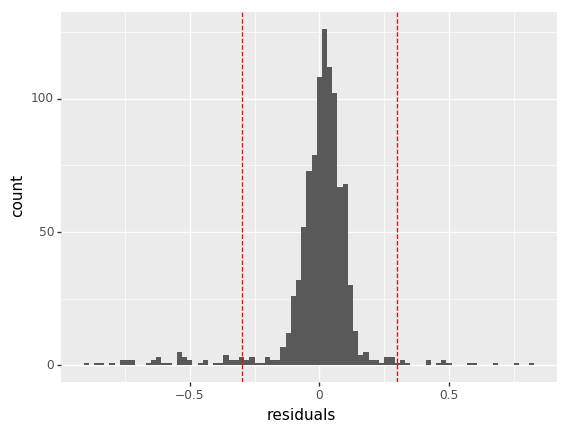

<ggplot: (7547680916)>

In [6]:
residuals = DataFrame(model.predict(X) - df1['y'].values, columns = ['residuals'])
sigma = residuals['residuals'].std()

q0 = norm.ppf(q=0.025,scale=sigma)
q1 = norm.ppf(q=0.975,scale=sigma)

p = ggplot(residuals)
p = p + geom_histogram(aes(x='residuals'), binwidth = 0.02)
p + geom_vline(aes(xintercept='x'), data=DataFrame([q0, q1], columns=['x']), color='red', linetype='--')

### Step III

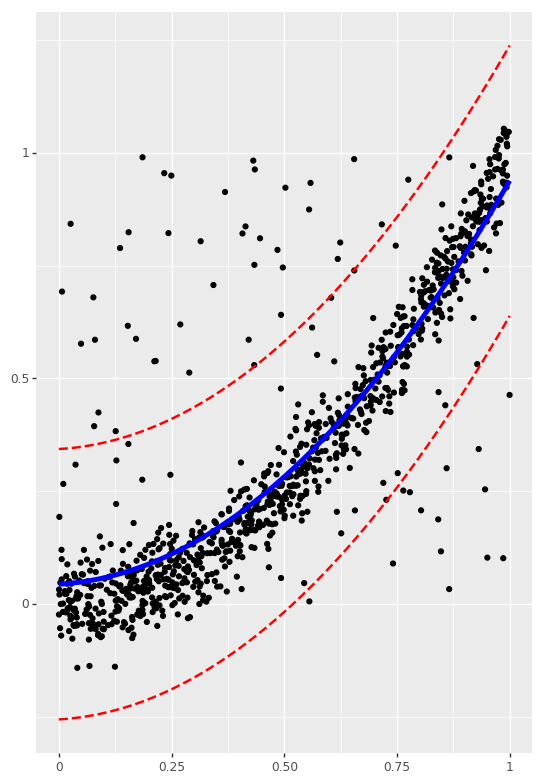

<ggplot: (7547777144)>

In [7]:
pred = (DataFrame(np.linspace(0,1,100), columns = ['x'])
        .assign(yhat = lambda df: model.predict(poly2.fit_transform(df[['x']])))
        .assign(y0 = lambda df: df['yhat'] + q0)
        .assign(y1 = lambda df: df['yhat'] + q1)
       )

p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_line(aes(x = 'x', y = 'yhat'), data = pred, color = 'blue', size=2)
p = p + geom_line(aes(x = 'x', y = 'y0'), data = pred, color = 'red', size=1, linetype='--')
p = p + geom_line(aes(x = 'x', y = 'y1'), data = pred, color = 'red', size=1, linetype='--')
display(p)

## V. Naive solution for the second task

* Find an initial guess for $x_0$.
* Split data according to $x_0$ into two clusters.
* Fit a linear model on both sub-datasets.
* Choose a new $x_0$ candidate so that prediction line is continuous.

### Step I

In [8]:
ClusterCat = CategoricalDtype([1,2], ordered=True)

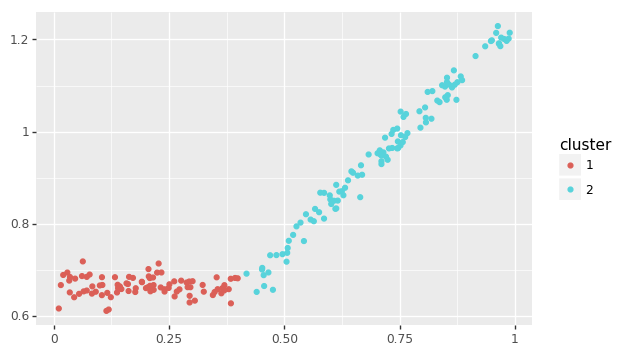

<ggplot: (-9223372029307004437)>

In [9]:
x0 = 0.4
df2 = df2.assign(cluster = lambda df: ((df['x'] >= x0) + 1).astype(ClusterCat))

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y', color ='cluster'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Step II

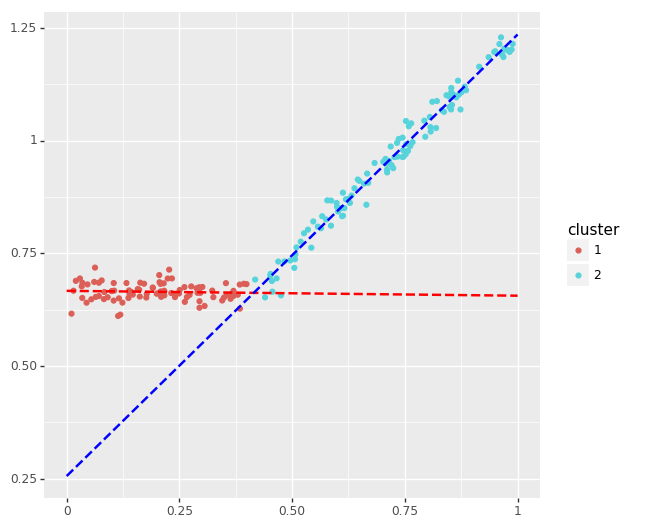

<ggplot: (7547771270)>

In [10]:
lm = LinearRegression(fit_intercept = True)
cluster1 = df2.loc[df2['cluster'] == 1]
cluster2 = df2.loc[df2['cluster'] == 2]

model1 = copy.copy(lm.fit(cluster1[['x']], cluster1['y']))
model2 = lm.fit(cluster2[['x']], cluster2['y'])

pred = (DataFrame(np.linspace(0,1,100), columns = ['x'])
        .assign(y1 = lambda df: model1.predict(df[['x']]))
        .assign(y2 = lambda df: model2.predict(df[['x']]))
       )

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y', color ='cluster'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_line(aes(x = 'x', y = 'y1'), data = pred, color = 'red', size=1, linetype='--')
p = p + geom_line(aes(x = 'x', y = 'y2'), data = pred, color = 'blue', size=1, linetype='--')
display(p)

# Homework

## 4.1 Naive implementation of robust polynomial regression (<font color='red'>1p</font>)

Write a function `naive_robust_lm` that repeats the naive outlier detection described in subsection IV several times to fit a model. Describe the convergence criterion and demonstrate that it works also for multivariate linear regression. Compare the prediction line, mean squared error (MSE), and the distribution of residues for the original model and residues for the `naive_robust_lm`. Which model gives the best MSE score and why? Which model has residue distribution that is closest to normal distribution? What is the catch in the last question? 

## 4.2 Robust polynomial regression with model based clustering (<font color='red'>2p</font>)

Let us define a probabilistic model that justifies the format of the naive algorithm. Let $\mathcal{D}_1$ be the data source for which $y\sim ax^2+bx+c+\varepsilon$ for $\varepsilon\sim\mathcal{N}(0,\sigma^2)$. Let $\mathcal{D}_2$ be the distribution that generates any outcome with probability $\alpha$. This distribution is called Poisson component.

* Express probability $p_1=\Pr[y_i|x_i, a,b,c, \sigma]$ for the first data source if all the model parameters  $a,b,c, \sigma$ are fixed. 
* Express probability $p_2=\Pr[y_i|x_i,\alpha]$ for the second data source if all the model parameters $\alpha$ are fixed.
* Based on these answers, implement step **M1**.
* What is the maximum likelihood estimate for the parameters $a,b,c$ if we know the cluster labels? How can you find it?
* How can you find the maximum likelihood estimate for $\sigma$?
* Based on these answers, implement step **M2**.
* For the initial guess **M0**, use linear regression to find initial estimates for the parameters $ a,b,c, \sigma$.


Implement the corresponding maximisation algorithm as `robust_lm`. Describe the convergence criterion and demonstrate that it works also for multivariate linear regression.
Show that the model indeed maximises the probability by computing the probability 

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max
\end{align*}

after each step. Plot the corresponding log-likelihood graph. Compare the prediction line, mean squared error (MSE), and the distribution of residues for the original model and residues for the `robust_lm`. Which model gives the best MSE score and why? Which model has residue distribution that is closest to normal distribution? What is the catch in the last question? 

In [11]:
poly2 = PolynomialFeatures(degree=2)
X=DataFrame(poly2.fit_transform(df1[['x']]),columns=[r'$x^0$', r'$x^1$', r'$x^2$'])
model = LinearRegression(fit_intercept=False)
model.fit(X, df1['y'])
w = DataFrame(model.coef_.reshape([1,3]), columns=[r'$x^0$', r'$x1$', r'$x^2$'])

In [12]:
df1 = (df1
       .assign(yhat = model.predict(X))
       .assign(residue = lambda df: df['y'] - df['yhat']))
sigma = df1['residue'].std() 
sigma

0.1529700744476937

In [13]:
df1 = (df1
       .assign(p1 = lambda df: norm.pdf(df1['residue'], scale = sigma)))
head(df1)

,x,y,yhat,residue,p1
0,0.728269,0.512820,0.529708,-0.016887,2.592132
1,0.909930,0.820282,0.789272,0.031011,2.554933
2,0.380931,0.250688,0.187123,0.063564,2.392264
3,0.245030,0.153003,0.108021,0.044982,2.497622
4,0.626321,0.156423,0.408227,-0.251804,0.672840


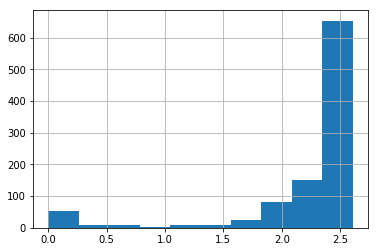

In [14]:
df1['p1'].hist()
alpha = 1

In [15]:
df1 = df1.assign(p2 = alpha)
head(df1)

,x,y,yhat,residue,p1,p2
0,0.728269,0.512820,0.529708,-0.016887,2.592132,1
1,0.909930,0.820282,0.789272,0.031011,2.554933,1
2,0.380931,0.250688,0.187123,0.063564,2.392264,1
3,0.245030,0.153003,0.108021,0.044982,2.497622,1
4,0.626321,0.156423,0.408227,-0.251804,0.672840,1


In [16]:
df1 = df1.assign(z = df1[['p1', 'p2']].idxmax(axis=1))
head(df1)

,x,y,yhat,residue,p1,p2,z
0,0.728269,0.512820,0.529708,-0.016887,2.592132,1,p1
1,0.909930,0.820282,0.789272,0.031011,2.554933,1,p1
2,0.380931,0.250688,0.187123,0.063564,2.392264,1,p1
3,0.245030,0.153003,0.108021,0.044982,2.497622,1,p1
4,0.626321,0.156423,0.408227,-0.251804,0.672840,1,p2


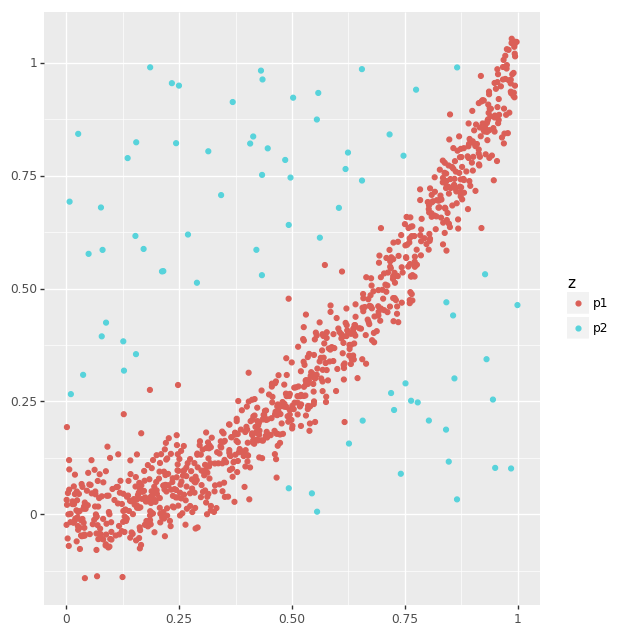

<ggplot: (-9223372029306997104)>

In [17]:
p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p

### M2

In [18]:
cluster1 = df1.loc[df1['z']=='p1']

In [19]:
X=DataFrame(poly2.fit_transform(cluster1[['x']]),columns=[r'$x^0$', r'$x^1$', r'$x^2$'])
model = LinearRegression(fit_intercept=False)
model.fit(X, cluster1['y'])
w = DataFrame(model.coef_.reshape([1,3]), columns=[r'$x^0$', r'$x1$', r'$x^2$'])

In [20]:
w

,$x^0$,$x1$,$x^2$
0,0.002464,0.016001,0.973786


In [21]:
cluster1 = (cluster1
            .assign(yhat = model.predict(X))
            .assign(residue = lambda df: df['y'] - df['yhat']))
sigma = cluster1['residue'].std() 
sigma

0.056500980142936794

### M1

In [22]:
X=DataFrame(poly2.fit_transform(df1[['x']]),columns=[r'$x^0$', r'$x^1$', r'$x^2$'])

df1 = (df1
       .assign(yhat = model.predict(X))
       .assign(residue = lambda df: df['y'] - df['yhat'])
       .assign(p1 = lambda df: norm.pdf(df['residue'], scale = sigma))
       .assign(z = lambda df: df[['p1', 'p2']].idxmax(axis=1))
      )

In [23]:
head(df1)

,x,y,yhat,residue,p1,p2,z
0,0.728269,0.512820,0.530591,-0.017770,6.720082,1,p1
1,0.909930,0.820282,0.823292,-0.003010,7.050791,1,p1
2,0.380931,0.250688,0.149864,0.100823,1.436803,1,p1
3,0.245030,0.153003,0.064851,0.088152,2.090659,1,p1
4,0.626321,0.156423,0.394481,-0.238058,0.000986,1,p2


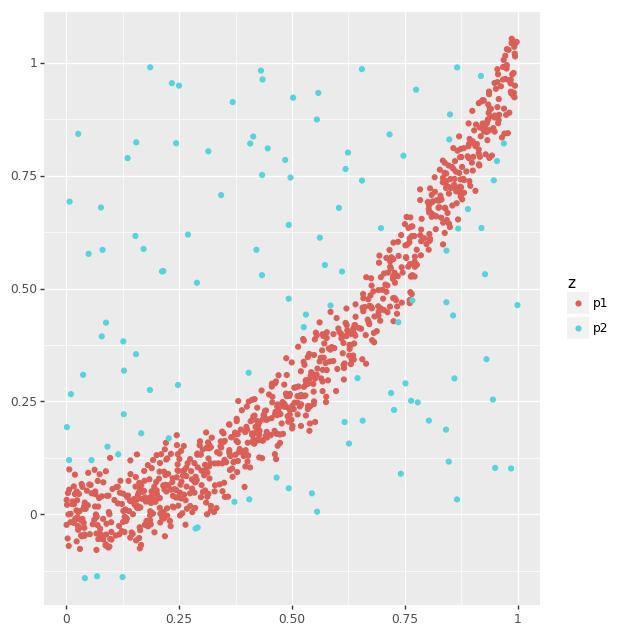

<ggplot: (7547246123)>

In [24]:
p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p

## 4.3 Naive implementation of piecewise linear regression (<font color='red'>1p</font>)

Write a function `naive_piecewise_lm` that repeats the naive method for the detection of split point $x_0$
described in subsection V several times to fit a model. Start from a worse position than we did in section V.
Describe the convergence criterion and demonstrate that it works for other datasets. Show how prediction lines, mean squared error, and the distribution of residues evolve over iterations. 

## 4.4 Piecewise linear regression with model based clustering (<font color='red'>2p</font>)

Let us define a probabilistic model that justifies the format of the naive algorithm. Let $\mathcal{D}_i$ be the data source for which $y\sim a_ix+b_i+\varepsilon$ for $\varepsilon\sim\mathcal{N}(0,\sigma^2)$. 

* Express probability $p_i=\Pr[y_i|x_i, a_i,b_i,\sigma]$ for the data source $\mathcal{D}_i$ if all the model parameters $a_i,b_i,\sigma$ are fixed. 
* Based on this answer, implement step **M1**.
* What is the maximum likelihood estimate for the parameters $a_i,b_i$ if we know the cluster labels? How can you find it?
* How can you find the maximum likelihood estimate for $\sigma$?
* Based on these answers, implement step **M2**.
* For the initial guess **M0**, use linear regression to find initial estimates for the parameters $a,b$. Find the split point $x_0$ so that the difference in mean values of residues on the left and right of $x_0$ is the biggest, and there are at least 10 data points in both clusters.

Implement the corresponding maximisation algorithm as `piecewise_lm`. Describe the convergence criterion and demonstrate that it works also for other datasets.
Show that the model indeed maximises the probability by computing the probability 

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max
\end{align*}

after each step. Plot the corresponding log-likelihood graph. Show how prediction lines, mean squared error, and the distribution of residues evolve over iterations. 